<h1 align="center"><font color='black'>Short Tau Exercise</font></h1>
<h2 align="center"> <font color='blue'>Part 1</font></h2>



<div class="alert alert-block alert-success">  
<b>Learning Objectives:</b>  

* __the reconstruction of hadronic tau decays in different decay modes__ (Part 1)
* discrimination of hadronic tau decays against jets, electrons, and muons. (Part 2)
</div>

Additional material:

* <a href="https://cms-results.web.cern.ch/cms-results/public-results/publications/TAU-20-001/index.html">
  TAU-20-001: Latest paper describing the HPS reconstruction and DeepTau identification algorithms for hadronic tau decays at CMS</a>.
  
    * Hardon-plus-strips (HPS) is an algorithm that reconstructs the different hadronic decay modes of the tau using tracks and calorimeter clusters inside a narrow jet cone.
    * DeepTau is a convolutional neural networks to discriminate jets, muons, and electrons that are misidentified as hadronic tau decays.
* <a href="http://cms-results.web.cern.ch/cms-results/public-results/publications/TAU-16-003/index.html">
  TAU-16-003: Previous paper on the HPS reconstruction</a>.

In [1]:
import ROOT
from dm_migration import dm_migration
from prettytable import PrettyTable

Welcome to JupyROOT 6.18/00


In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false
}

<IPython.core.display.Javascript object>

### How do taus actually decay?
Here's a table from the [TAU-20-001 paper](https://cms-results.web.cern.ch/cms-results/public-results/publications/TAU-20-001/index.html#Table_001)
linked above that associates the different tau decay modes together with their branching fractions and whether the decay proceeds via an intermediate resonance:

<img src="docs/tau_decays.png" width="600">   <img src="docs/piechart_tau.png" width="350">

Since decays of tau leptons to electrons or muons and neutrinos are experimentally very different with respect to decays to hadrons and a neutrino, they are covered by different physics object groups. In the CMS tau reconstruction, we focus only on reconstructing hadronic tau decays.

### Inputs for the exercise
The ROOT files used in this exercise are created from simulated events in the CMS detector. 

__Contents of the ROOT files:__ (Contents preprocessed using tau validation tools <a href="https://github.com/cms-tau-pog/TauReleaseValidation">here</a>)
* Generated hadronic tau decays
* Other generated particles
* Information about spatially matched reconstructed hadronic tau decays (To study tau reconstruction efficiency)


__Additional Information__:
* In the ROOT files, a TTree "per tau" is found that contains one entry per generated tau
* The branches for reconstructed taus are only filled with values different from `-999` if a reconstructed hadronic tau was found (Allows to study which fraction of taus was successfully reconstructed)
* Reconstructed taus have `pt > 18 GeV` and `|eta| < 2.3`
* Generated taus have `pt > 10 GeV` and `|eta| < 2.3`

Given that our reconstruction targets hadronic taus with `pt > 20 GeV`, we usually restrict to this range.  

<div class="alert alert-block alert-warning">  
<b>Note:</b> 
Many analyses actually apply tighter cuts, e.g. `pt > 30 GeV`, and it will be interesting to check at each stage in this notebook how things change when increasing the pT cut even if you're not explicitly asked to do so
</div>

In [3]:
base_dir = '/eos/user/c/cmsdas/2024/short-ex-tau' # if you're running from swan.cern.ch
#base_dir = './inputFiles/' # if you're running from local after downloading the input root files
tau_sample = f'{base_dir}/dy_nanoaod_v6_gen_tuple.root'
tau_file = ROOT.TFile.Open(tau_sample)
tau_tree = tau_file.Get('tree')

In this notebook, one can investigate which variables are contained in the tree and how they are distributed. One can also investigate this by other means such as with a TBrowser.

In [4]:
# Print all branch names
x = PrettyTable()
x.field_names = ["Branches"]
branch_names = [g.GetName() for g in tau_tree.GetListOfBranches()]
[x.add_row([name]) for name in branch_names]
print(x)

+------------------------------+
|           Branches           |
+------------------------------+
|             run              |
|             lumi             |
|            event             |
|             nvtx             |
|            ngvtx             |
|             rho              |
|             gpud             |
|             npu              |
|           ntrueint           |
|             pud              |
|             eoot             |
|             loot             |
|            tau_pt            |
|           tau_eta            |
|           tau_phi            |
|           tau_mass           |
|           tau_dxy            |
|            tau_dz            |
|          tau_charge          |
|        tau_decayMode         |
|        tau_chargedIso        |
|      tau_leadTkDeltaEta      |
|      tau_leadTkDeltaPhi      |
|    tau_leadTkPtOverTauPt     |
|        tau_neutralIso        |
| tau_photonsOutsideSignalCone |
|          tau_puCorr          |
|        t

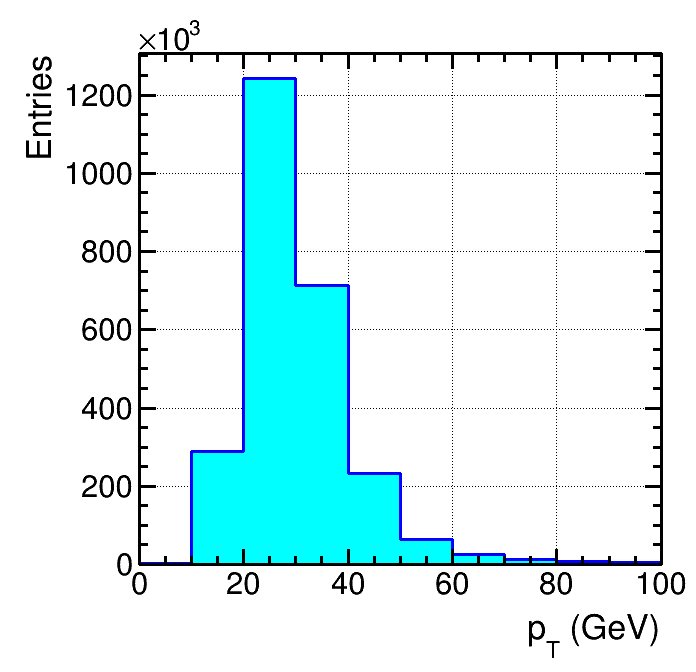

In [5]:
# Manually draw distributions of variables obtained from the following list, like one would do with a TBrowser
cv = ROOT.TCanvas()
cv.SetFillColor(0)  # Set canvas background color

tau_tree.Draw('tau_pt>>h(10,0,100)', 'tau_pt > 0. && tau_pt<100') # only draw if tau was actually reconstructed
#tau_tree.Draw('tau_pt>>h(10,0,200)')

h = ROOT.gROOT.FindObject("h")
h.SetLineColor(ROOT.kBlue)  # Set line color for histogram
h.SetFillColor(ROOT.kCyan)  # Set fill color for histogram
h.SetLineWidth(3)  # Set line width for histogram

h.SetTitle("")
h.GetXaxis().SetTitle("p_{T} (GeV)")  # Set x-axis label
h.GetYaxis().SetTitle("Entries")  # Set y-axis label
cv.Draw()

### CMS Tau Reconstruction

#### Old decay modes
The CMS tau reconstruction originally focussed on three main decay modes:
* __One-prong__ (decay mode 0) 
* __One-prong + $\pi_{0}$__ (decay modes 1/2/3/4)
* __Three-prong__ - (decay mode 10)

In the tau reconstruction code, we give integer values to the decay modes via the convention
$$
\mathrm{DM} = 5 \times ( N_\mathrm{charged} - 1 ) + N_{\pi^{0}}
$$
where $N_\mathrm{charged}$ is the number of charged hadrons ($\pi^\pm$, $\mathrm{K}^\pm$, ...), and $N_\mathrm{\pi^{0}}$ is the number of neutral pions ($\pi^{0}$).
The values of the decay modes above are shown between the parentheses.

To check whether a tau is reconstructed in any of these "old" decay modes, there is a flag __`tau_decayModeFinding`__.

#### New decay modes
Later, during Run 2, the HPS algorithm was updated, and "new" decay modes became available.
* __Three-prong + $\pi_{0}$__ (decay mode 11)

Furthermore, we also try to reconstruct taus that have a 3-prong decay on generator level (decay modes 10, 11) but where one charged hadron is not reconstructed.
These new reconstructed decay modes are sometimes called "2-prong modes":
* __3-prong with missing charged hadron and no $\pi_{0}$__ (reco decay mode 5)
* __3-prong with missing charged hadron and $\pi_{0}$__ (reco decay mode 6)

There is a flag __`tau_decayModeFindingNewDMs`__ that checks if the tau was reconstructed in any of the new decay modes.
Because the "new" decay modes are standard in Run 2, this flag is always true for reconstructed taus in the considered trees (and in MiniAOD),
so we do not explicitly check it in the examples below.

<img src="docs/tau_decay_signatures.png" width="1000">

<div class="alert alert-block alert-warning">  
<b>Note:</b> 
For simplicity, we do not separately look at old decay modes only (<b>tau_decayModeFinding</b>) below. It can be an interesting exercise to see how much the overall reconstruction efficiency decreases when considering only these old decay modes
</div>

<div class="alert alert-block alert-info">
<b> Let's investigate how efficiently taus are reconstructed</b>
</div>

In [6]:
# We're interested in taus well within the tracker acceptance and with minimum pT
base_sel = 'tau_gen_pt>20. && abs(tau_gen_eta)<2.3'

n_all = tau_tree.Draw('1', base_sel)
n_pass = tau_tree.Draw('1', 'tau_pt>20 &&' + base_sel)
print("Out of", n_all,'generated taus', n_pass, 'are reconstructed')
efficiency = f'{n_pass/n_all:.3f}'
print(f'Efficiency: \033[1;32m{efficiency}\033[0m')

# Let's consider the old decay modes
n_pass = tau_tree.Draw('1', 'tau_idDecayMode && tau_pt>20 &&' + base_sel)
print("Out of",n_all,"generated taus", n_pass, "also pass the 'old' decay mode finding")
efficiency = f'{n_pass/n_all:.3f}'
print(f'Efficiency: \033[1;31m{efficiency}\033[0m')

Out of 2916433 generated taus 2134293 are reconstructed
Efficiency: 0.732
Out of 2916433 generated taus 1770703 also pass the 'old' decay mode finding
Efficiency: 0.607


### How does the inclusive reconstruction efficiency come about?

The tau reconstruction proceeds as follows:
* First, the tau reconstruction is seeded by a jet (this step is very efficient)
* Second, charged hadron candidates are identified and $\pi_{0}$ candidates are reconstructed from photons (the latter need to fulfil some minimal criteria)
* Third, all possible tau candidates are built from the charged hadrons and $\pi_{0}$s, with the charged hadrons and pi0s required to be in a narrow cone around the reconstructed tau axis. The reconstructed taus are also checked for compatibility with the masses of intermediate resonances __$\rho$(770 MeV) and $\alpha_{0}$(1260 MeV)__.
* Fourth, the best tau candidate is retained. Of all taus that are reconstructed in one of the decay modes including cuts on the mass compatibility, the one with highest pT is retained.

<img src="docs/HPS.png" width="380">

**Which effects do you think limit the tau reconstruction efficiency?**

There are at least 3 relevant effects:
* The reconstruction efficiency for individual tau decay products, in particular for charged hadrons, is limited: In particular, the reconstruction efficiency for charged hadrons is 90% to good approximation and regardless of pT. *What does this imply for 1-prong and 3-prong taus?*
* For taus near the kinematic threshold, which we chose above to be 20 GeV, the reconstructed pT may be lower than the generated one.
* A wrong tau candidate may be selected as the best tau candidate, which can happen in particular if the mass compatibility criteria fail.

<div class="alert alert-block alert-info">
<b>To study the first, it's useful to check the efficiency per decay mode.</b>
</div>

#### Decay Mode 0

In [7]:
base_sel = 'tau_gen_pt>20. && abs(tau_gen_eta)<2.3 && tau_gen_decayMode==0'
n_all = tau_tree.Draw('1', base_sel)
n_pass = tau_tree.Draw('1', 'tau_pt>20 &&' + base_sel)
print(f'Efficiency: {n_pass/n_all:.3f}')

Efficiency: 0.874


The efficiency is nearly 90% for 1-prong taus without $\pi_{0}$, which is in line with our expectation that the reconstruction efficiency is merely limited by the charged hadron reconstruction efficiency.

<div class="alert alert-block alert-warning">  

<b>Can you print the inclusive reconstruction efficiencies for the other decay modes?</b>

<b>Hint</b>: Use generated decay modes 1 and 2 for 1-prong + $\pi_{0}$; decay mode 10 for 3-prong taus; and decay mode 11 for 3-prong taus + $\pi_{0}$
    
</div>

In [8]:
# Your code goes here
for gen_dm in [0, 1, 2, 10, 11]:
    print(f'Investigating Tau Decay Mode {gen_dm}')
    base_sel = f'tau_gen_pt>20. && abs(tau_gen_eta)<2.3 && tau_gen_decayMode=={gen_dm}'
    n_all = tau_tree.Draw('1', base_sel)
    n_pass = tau_tree.Draw('1', 'tau_pt>20 &&' + base_sel)
    efficiency = f'{n_pass/n_all:.3f}'
    print(f'Efficiency: \033[1;31m{efficiency}\033[0m\n')

Investigating Tau Decay Mode 0
Efficiency: 0.874

Investigating Tau Decay Mode 1
Efficiency: 0.715

Investigating Tau Decay Mode 2
Efficiency: 0.639

Investigating Tau Decay Mode 10
Efficiency: 0.843

Investigating Tau Decay Mode 11
Efficiency: 0.743



<div class="alert alert-block alert-warning">  

Besides reconstructing the tau at all, it may also be interesting to understand whether the tau is actually reconstructed in its corresponding decay mode. 

<b>Can you check how often taus are reconstructed in the correct decay mode? </b>
    
</div>

In [15]:
# Your code goes here
# Hint: use an expression like 'tau_decayMode == 0' when you calculate the number of passing events
for gen_dm in [0, 1, 2, 10, 11]:
    print(f'Investigating Tau Decay Mode {gen_dm}')
    base_sel = f'tau_gen_pt>20. && abs(tau_gen_eta)<2.3 && tau_gen_decayMode=={gen_dm}'
    n_all = tau_tree.Draw('1', base_sel)
    n_pass = tau_tree.Draw('1', f'tau_pt>20 && tau_decayMode=={gen_dm} &&' + base_sel)
    efficiency = f'{n_pass/n_all:.3f}'
    print(f'Efficiency: \033[1;31m{efficiency}\033[0m\n')

Investigating Tau Decay Mode 0
Efficiency: 0.794

Investigating Tau Decay Mode 1
Efficiency: 0.523

Investigating Tau Decay Mode 2
Efficiency: 0.000

Investigating Tau Decay Mode 10
Efficiency: 0.592

Investigating Tau Decay Mode 11
Efficiency: 0.334



<div class="alert alert-block alert-info">
<b>Not only the reconstruction efficiency for single particles limits the tau efficiency, but also the pT resolution of the reconstructed particles and the criteria we impose on the mass. Let's investigate how they look!</b>
</div>

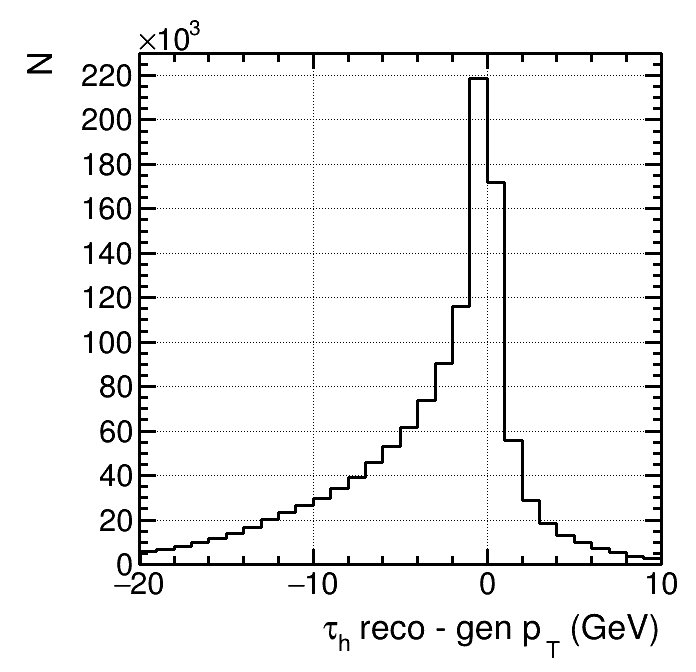

In [10]:
# We use a minimum generated pT of 30. so we do not run into threshold effects 
# given we only have reconstructed taus with pT > 18 GeV in the trees
base_sel = 'tau_gen_pt>30. && abs(tau_gen_eta)<2.3'
h_res = ROOT.TH1F('h_res', '', 30, -20., 10.)
h_res.GetXaxis().SetTitle("#tau_{h} reco - gen p_{T} (GeV)")
h_res.GetYaxis().SetTitle("N")
tau_tree.Project('h_res', 'tau_pt - tau_gen_pt', base_sel)
canvas = ROOT.TCanvas()
h_res.Draw()
canvas.Draw()

<div class="alert alert-block alert-warning">  

There is a nice peak at 0, as one would expect, but also a tail towards lower reconstructed values.

<b>Can you find out if this tail comes from particular generated decay modes?</b>
</div>    

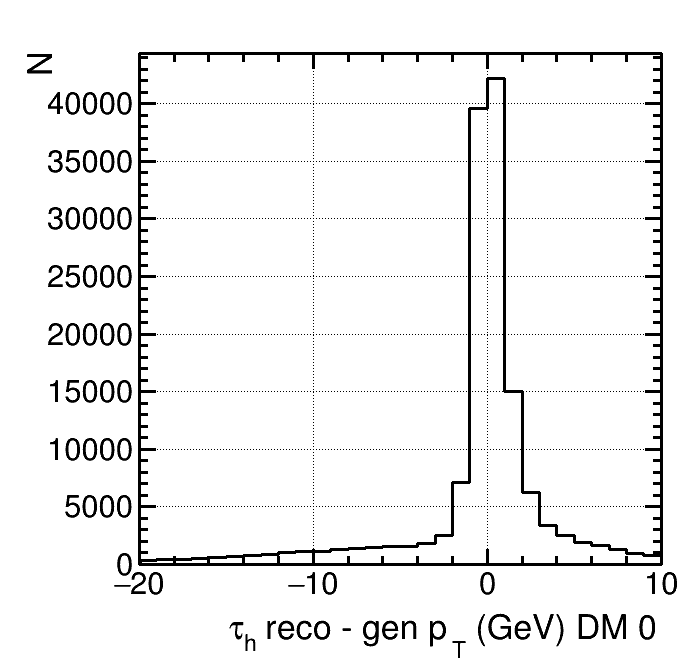

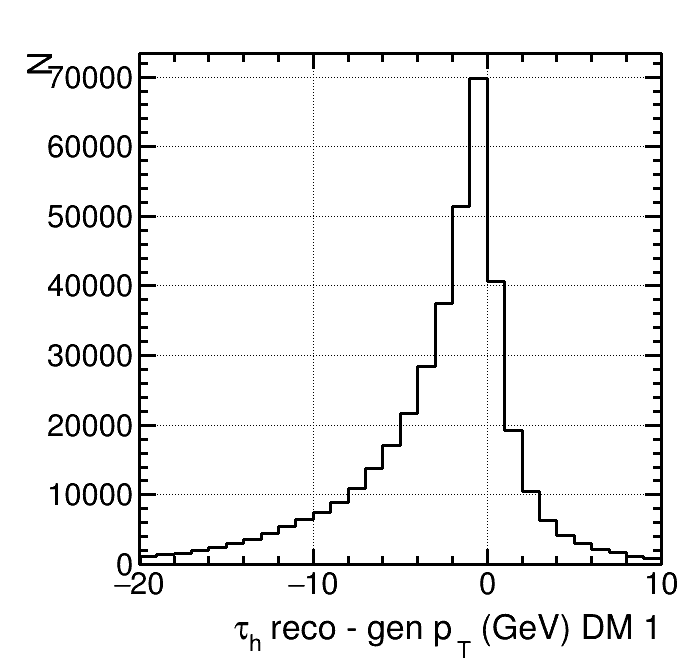

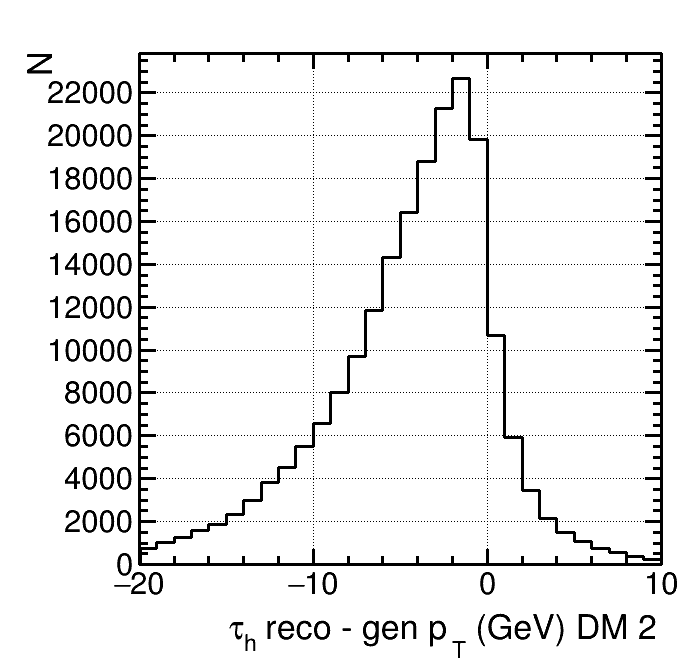

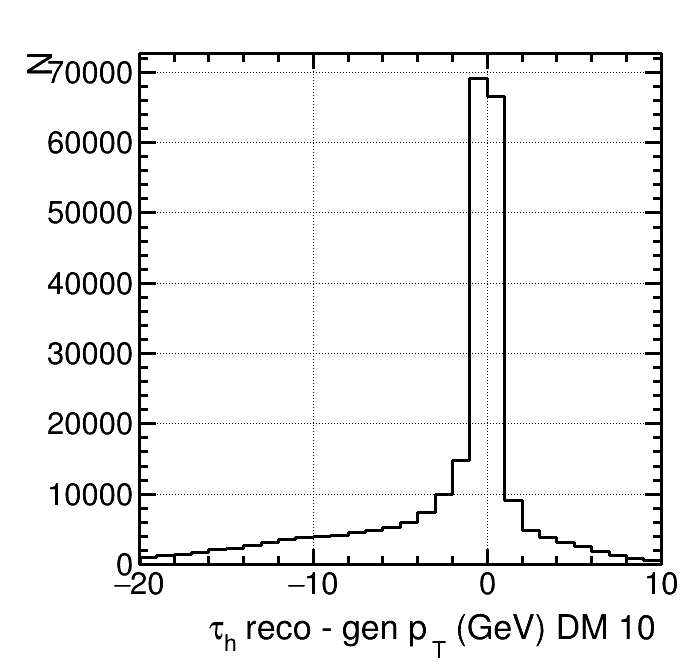

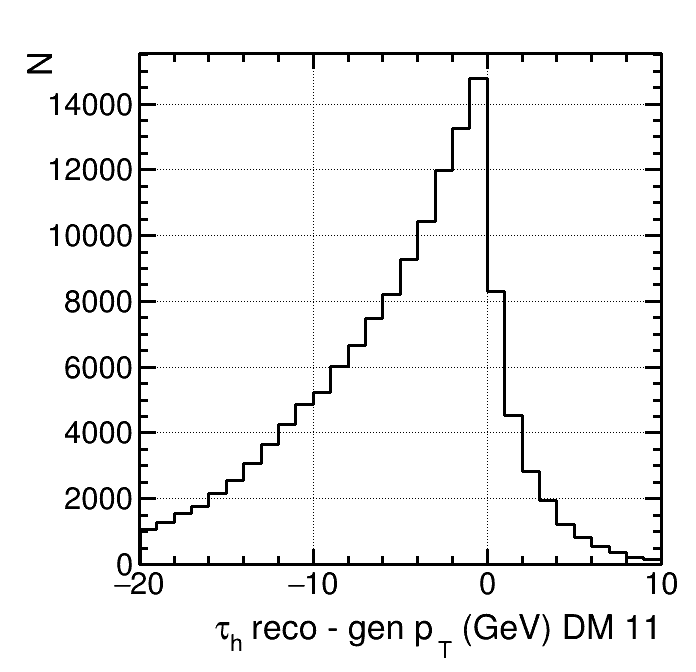

In [16]:
# Your code goes here.
# Hint: Select a specific generated decay mode in the base_sel string.
# It can also be interesting to see if these tails arise if taus are reconstructed in a wrong decay mode.
garbage_collector = {}
for gen_dm in [0, 1, 2, 10, 11]:
    base_sel = f'tau_gen_pt>30. && abs(tau_gen_eta)<2.3 && tau_gen_decayMode == {gen_dm}'
    h_res_name = f'h_res_{gen_dm}'  # Unique histogram name
    h_res = ROOT.TH1F(h_res_name, '', 30, -20., 10.)
    h_res.GetXaxis().SetTitle(f"#tau_{{h}} reco - gen p_{{T}} (GeV) DM {gen_dm}")
    h_res.GetYaxis().SetTitle("N")
    tau_tree.Project(h_res_name, 'tau_pt - tau_gen_pt', base_sel)
    canvas = ROOT.TCanvas()
    garbage_collector[gen_dm] = (canvas, h_res)  # Cache histograms to prevent python garbage collection
    h_res.Draw()
    canvas.Draw()

To draw a nice plot of the decay mode migration matrix, we can use a short script that makes decay mode migration plots from a passed TTree. This plot gives very useful diagnostic information about the tau reconstruction since it gives the fractions of taus that are reconstructed in the right decay mode, in any decay mode, and of those that are not reconstructed at all.

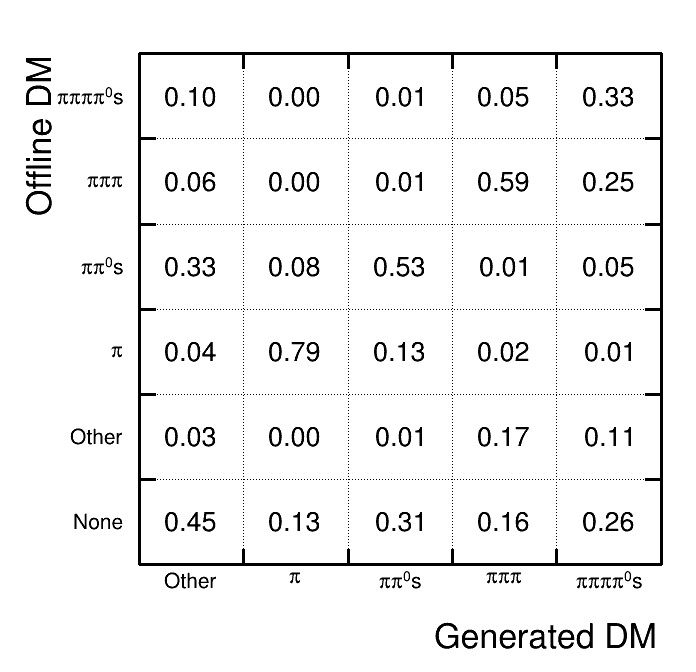

In [12]:
canvas = dm_migration(tau_tree,canvas_title='decay_mode_matrix')
canvas.Draw()

<div class="alert alert-block alert-warning">  
The function takes as one possible argument a generator cut, which is by default set to
`gen_cut='tau_genpt>20 && abs(tau_geneta)<2.3'`

<b>Does the decay mode matrix change for higher tau pT?</b>
</div>

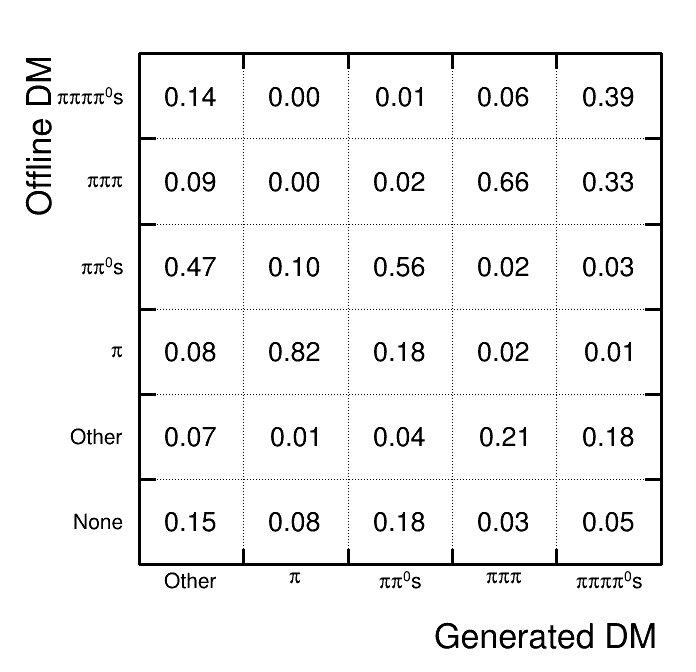

In [17]:
# Your code to make the plot with different generator cuts goes here
canvas = dm_migration(tau_tree, gen_cut='tau_gen_pt>60 && abs(tau_gen_eta)<2.3',title='high_pT',canvas_title='decay_mode_matrix_high_pT')
canvas.Draw()

<div class="alert alert-block alert-warning">  
<b>Advanced exercise:</b>

Investigate the dm_migration script: It takes as additional arguments a string that converts the decay mode information to integers and a list of labels. Can you divide the 1-prong + $\pi_{0}$ decay modes into ones with a single $\pi_{0}$ and ones with more than 1 $\pi_{0}$? Is our reconstruction able to disentangle taus with different numbers of $\pi_{0}$?
</div>

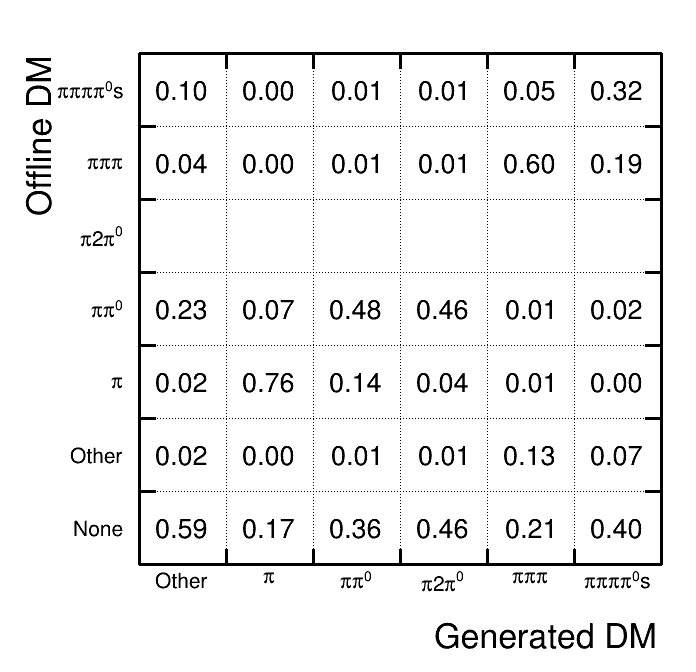

In [18]:
# Your code goes here
tau_decayMode_string = ('-2'
                         '+ (tau_pt>30 && tau_decayMode>=0 && tau_decayMode <200)*(1 ' # will contain reco DM 5 and 6 and other gen DMs
                            '+ (tau_decayMode==0)'
                            '+ 2*(tau_decayMode==1)'
                            '+ 3*(tau_decayMode==2)'
                            '+ 4*(tau_decayMode==10)'
                            '+ 5*(tau_decayMode==11))'
            )
labels = ['None', 'Other', '#pi', '#pi#pi^{0}', '#pi2#pi^{0}', '#pi#pi#pi', '#pi#pi#pi#pi^{0}s']
canvas = dm_migration(tau_tree, tau_decayMode_string=tau_decayMode_string, labels=labels,title='split_pi0',canvas_title='decay_mode_matrix_split_pi0')
canvas.Draw()